In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx

## Data processing

In [2]:
net = pn.case6ww()

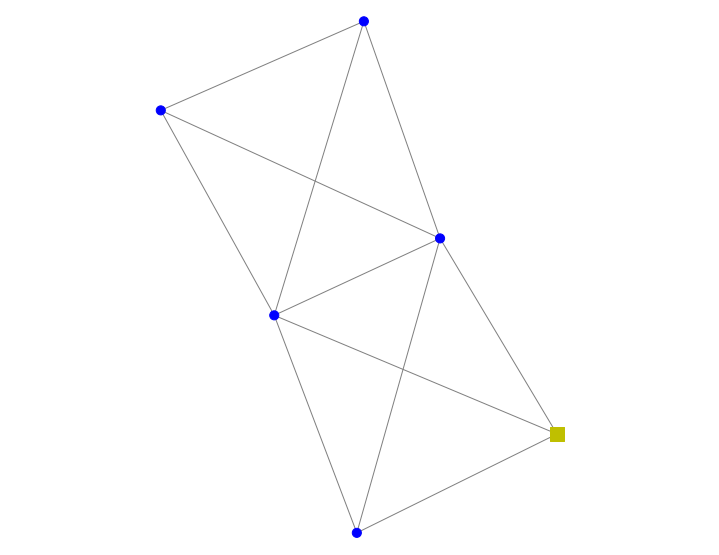

<AxesSubplot:>

In [31]:
simple_plot(net)

In [3]:
# currently the sn_mva (base power) is inconsistent with that in the original MATPOWER cases
net.sn_mva = 100

In [4]:
n = len(net.bus)

#### Generators

In [5]:
gen_df_list = []
gen_name_list = ["gen", "sgen", "ext_grid"]
data_col_list = ["bus", "max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]

for gen_name in gen_name_list:
    if not net[gen_name].empty:
        # get a table of cost coefficients only for the current type of generators
        gen_name_poly_cost = net.poly_cost.loc[net.poly_cost.et == gen_name].set_index("element")
        # get a table of cost coefficients and power bounds only for the current type of generators
        gen_name_df = net[gen_name][data_col_list].join(gen_name_poly_cost)
        gen_df_list.append(gen_name_df)

# combine tables for all types of generators
gen_df = pd.concat(gen_df_list).reset_index()
n_gen = len(gen_df)

In [6]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,1,150.0,37.5,100.0,-100.0,gen,200.0,10.333,0.00889,0.0,0.0,0.0
1,1,2,180.0,45.0,100.0,-100.0,gen,240.0,10.833,0.00741,0.0,0.0,0.0
2,0,0,200.0,50.0,100.0,-100.0,ext_grid,213.1,11.669,0.00533,0.0,0.0,0.0


#### Bus loads

In [7]:
load_df = net.bus.join(net.load[["bus", "p_mw", "q_mvar"]].set_index("bus")).fillna(0)[["p_mw", "q_mvar"]]

In [8]:
load_df

,p_mw,q_mvar
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,70.0,70.0
4,70.0,70.0
5,70.0,70.0


#### Admittance matrices

In [9]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

In [10]:
G_val = np.zeros((n,n))
B_val = np.zeros((n,n))
for i,j in graph.edges:
    edge = graph.edges[(i,j)]
    r = edge["r_pu"]
    x = edge["x_pu"]
    G_val[i][j] = 1/r
    G_val[j][i] = 1/r
    B_val[i][j] = 1/x
    B_val[j][i] = 1/x

In [11]:
G_row_sums = np.sum(G_val, axis=1)
B_row_sums = np.sum(B_val, axis=1)
for i in range(n):
    shunt_row = net.shunt.loc[net.shunt["bus"] == i]
    g = 0  # shunt conductance
    b = 0  # shunt susceptance
    # if both are 0, there will be no data in the shunt dataframe
    if not shunt_row.empty:
        g = shunt_row["p_mw"].to_numpy()[0]
        b = -shunt_row["q_mvar"].to_numpy()[0]
    G_val[i][i] = g - G_row_sums[i]
    B_val[i][i] = b - B_row_sums[i]

## Variables

In [12]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [13]:
p_d_val = load_df[["p_mw"]].to_numpy()
q_d_val = load_df[["q_mvar"]].to_numpy()

In [14]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), nonneg=True, value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy())
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy())
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy())
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy())

## Constraints

In [15]:
constraints = [X >> 0]

In [16]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

In [17]:
constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [18]:
constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

## Solving

In [19]:
p_cost = cp.sum(gen_df["cp2_eur_per_mw2"].to_numpy() @ cp.square(p_g) +
                gen_df["cp1_eur_per_mw"].to_numpy() @ p_g +
                gen_df[["cp0_eur"]].to_numpy())
q_cost = cp.sum(gen_df["cq2_eur_per_mvar2"].to_numpy() @ cp.square(q_g) +
                gen_df["cq2_eur_per_mvar2"].to_numpy() @ q_g +
                gen_df[["cp0_eur"]].to_numpy())

In [20]:
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

In [21]:
prob.is_dcp()

True

In [22]:
prob.is_dpp()

True

In [23]:
prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)

The optimal value is inf
A solution X is
None


In [24]:
prob.status

'infeasible'

In [25]:
X_test = np.array([[1.1025    +0.j        , 1.10217827+0.02663309j,
        1.123092  +0.03027538j, 1.03598829+0.04829751j,
        1.03224624+0.06220358j, 1.05293071+0.06416317j],
       [1.10217827-0.02663309j, 1.1025    +0.j        ,
        1.12349562+0.00313601j, 1.03685269+0.02325704j,
        1.03344766+0.03724945j, 1.05417343+0.0387088j ],
       [1.123092  -0.03027538j, 1.12349562-0.00313601j,
        1.1449    +0.j        , 1.0566643 +0.02075067j,
        1.05323423+0.03501923j, 1.07435885+0.03644741j],
       [1.03598829-0.04829751j, 1.03685269-0.02325704j,
        1.0566643 -0.02075067j, 0.97560489+0.j        ,
        0.97269778+0.01323107j, 0.99222024+0.01416632j],
       [1.03224624-0.06220358j, 1.03344766-0.03724945j,
        1.05323423-0.03501923j, 0.97269778-0.01323107j,
        0.96997877+0.j        , 0.98945574+0.00066769j],
       [1.05293071-0.06416317j, 1.05417343-0.0387088j ,
        1.07435885-0.03644741j, 0.99222024-0.01416632j,
        0.98945574-0.00066769j, 1.00932426+0.j        ]])

In [26]:
pq_g_test = np.array([[76.72328296, 61.25990873],
                     [73.56969147, 85.79073847],
                     [66.45887933, 29.40322149]])

In [27]:
i = 0
gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
print([pq_g_test[k, 0] for k in gen_list])
print(np.sum([pq_g_test[k, 0] for k in gen_list]) - p_d_val[i])
print([G_val[i][j] * np.real(X_test[i][j]) + B_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)])
print(G_val[i][i] * X_test[i][i])
print(G_val[i][i] * X_test[i][i] + np.sum([G_val[i][j] * np.real(X_test[i][j]) + B_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))
print([pq_g_test[k, 1] for k in gen_list])
print(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i])
print([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)])
print(-B_val[i][i] * X_test[i][i])
print(-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))

[66.45887933]
[66.45887933]
[11.154948149999997, 20.961253349999996, 13.110423266666668]
(-46.85625+0j)
(-1.6296252333333427+0j)
[29.40322149]
[29.40322149]
[-5.24456045, -4.213991249999999, -2.6632760500000003]
(14.700000000000001+0j)
(2.5781722500000015+0j)


In [28]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print(np.sum([pq_g_test[k, 0] for k in gen_list]) - p_d_val[i])
    print(G_val[i][i] * X_test[i][i] + np.sum([G_val[i][j] * np.real(X_test[i][j]) + B_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))
    print(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i])
    print(-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))

[66.45887933]
(-1.6296252333333427+0j)
[29.40322149]
(2.5781722500000015+0j)
[76.72328296]
(-1.84749624809524+0j)
[61.25990873]
(2.2329140438095223+0j)
[73.56969147]
(-4.232407110512824+0j)
[85.79073847]
(3.1950668905128197+0j)
[-70.]
(1.977108175000005+0j)
[-70.]
(-2.272062874999996+0j)
[-70.]
(1.8181410371794797+0j)
[-70.]
(-2.312399882692306+0j)
[-70.]
(3.1335029952381035+0j)
[-70.]
(-3.190393607142859+0j)


In [29]:
G_val

array([[-42.5       ,  10.        ,   0.        ,  20.        ,
         12.5       ,   0.        ],
       [ 10.        , -74.28571429,  20.        ,  20.        ,
         10.        ,  14.28571429],
       [  0.        ,  20.        , -78.33333333,   0.        ,
          8.33333333,  50.        ],
       [ 20.        ,  20.        ,   0.        , -45.        ,
          5.        ,   0.        ],
       [ 12.5       ,  10.        ,   8.33333333,   5.        ,
        -45.83333333,  10.        ],
       [  0.        ,  14.28571429,  50.        ,   0.        ,
         10.        , -74.28571429]])

In [30]:
B_val

array([[-13.33333333,   5.        ,   0.        ,   5.        ,
          3.33333333,   0.        ],
       [  5.        , -27.33333333,   4.        ,  10.        ,
          3.33333333,   5.        ],
       [  0.        ,   4.        , -17.84615385,   0.        ,
          3.84615385,  10.        ],
       [  5.        ,  10.        ,   0.        , -17.5       ,
          2.5       ,   0.        ],
       [  3.33333333,   3.33333333,   3.84615385,   2.5       ,
        -16.34615385,   3.33333333],
       [  0.        ,   5.        ,  10.        ,   0.        ,
          3.33333333, -18.33333333]])